## Crop/select aera and calculate cloud fraction should be done in the same period.

In [178]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline

In [179]:
#path = '/uio/lagringshotell/geofag/students/metos/hannasv/MSG_0_degree_2009/'
#add = "archive.eumetsat.int/umarf/onlinedownload/hannasv/1336736/"

In [180]:
path = '/home/hanna/Desktop/master_thesis/meteosat0/'
era_path = '/home/hanna/Desktop/master_thesis/era/'

In [181]:
files = glob.glob(path+"*.grb")

In [182]:
grb_file = grb_files[0]

In [183]:
first_file = files[0]

In [184]:
files

['/home/hanna/Desktop/master_thesis/meteosat0/MSG4-SEVI-MSGCLMK-0100-0100-20190515001500.000000000Z-20190515002918-1333744.grb',
 '/home/hanna/Desktop/master_thesis/meteosat0/MSG4-SEVI-MSGCLMK-0100-0100-20190515000000.000000000Z-20190515001341-1333744.grb']

In [185]:
import datetime

In [186]:
def timestamp(filename):
    """
    Returns the np.datetime64 [ns] for the current date.
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:-1]
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

In [187]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)

    # TODO :: dimensions with coordinates
    #data = data.assign_coords(latitude = np.arange(-67.5, 67.5, 3712))
    #data = data.assign_coords(longitude = np.arange(-67.5, 67.5, 3712))    
    
    data['xgrid_0'] = np.linspace(-67.5, 67.5, 3712)
    data['ygrid_0'] = np.linspace(-67.5, 67.5, 3712)

    
    data = data.expand_dims(dim = 'time' )
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={'xgrid_0': 'longitude', 
                                  'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # TODO :: import region
    data = data.sel(latitude = slice(30,60))
    data = data.sel(longitude = slice(-15, 42))

    # Check that it contains no 4's
    nr_4 = (data.tcc == 3.0).sum().values
    if nr_4 > 0:
        print( nr_4 )
    else:
        print("We are all good.")
        
    # Replace values --> final result cloud = 1, no_cloud = 0.
    # currently not replacing any values.
    data = data.where(data.tcc - 1 < 0.0001, 0)
        
    return data

In [188]:
np.linspace(-67.5, 67.5, 3712)

array([-67.5       , -67.46362167, -67.42724333, ...,  67.42724333,
        67.46362167,  67.5       ])

In [189]:

#np.sqrt(13778944)

In [190]:
dset = fix_one_sat_file(first_file)
dset1 = fix_one_sat_file(files[1])

/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


79645
79645


/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: FutureWarning: The inplace argument has been deprecated and will be removed in a future version of xarray.


In [17]:
dset.merge(dset1)

<xarray.Dataset>
Dimensions:    (latitude: 824, longitude: 1567, time: 2)
Coordinates:
  * time       (time) datetime64[ns] 2019-05-15 2019-05-15T00:15:00
  * longitude  (longitude) float64 -14.97 -14.93 -14.9 ... 41.93 41.96 42.0
  * latitude   (latitude) float64 30.03 30.07 30.1 30.14 ... 59.9 59.93 59.97
Data variables:
    tcc        (time, latitude, longitude) float32 1.0 1.0 1.0 ... 0.0 0.0 0.0

In [18]:
#(dset.tcc == 3.0).sum().values

## Retrieving coordinates from nc file. 
### Notes a nc is 10 times as large as a grib file that is why we only have one of them

In [19]:
nc_path = '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/'
nc_files = glob.glob(nc_path+"*EUMETSAT*.nc")

sat_path = '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/'

In [20]:
nc_files = glob.glob(nc_path+"*EUMETSAT*.nc")
grb_files = glob.glob(sat_path + "*grb")

In [21]:
first_file = grb_files[0]

In [22]:
grb_files

['/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612113000.000000000Z-20190612114350-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190613053000.000000000Z-20190613054348-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612233000.000000000Z-20190612234401-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612173000.000000000Z-20190612174350-1338650.grb']

In [23]:
nc_files

['/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190612113000.nc',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190613053000.nc',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190612233000.nc',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/W_XX-EUMETSAT-Darmstadt,SING+LEV+SAT,MSG4+CLM_C_EUMG_20190612173000.nc']

In [24]:
from netCDF4 import Dataset


In [25]:
import seaborn as sns

In [26]:
#sns.heatmap(cloud_mask_array)

In [27]:
data = xr.open_dataset(first_file, engine="pynio")

ts = timestamp(first_file)
data['time'] = ts

# Add time as a coordinate and dimension. 
data = data.assign_coords(time = data.time)

In [28]:
data['CLOUDM_P30_GSV0_I207'].values

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

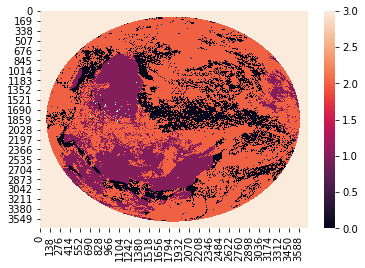

In [29]:
sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)

In [30]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [31]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)
    data = data.expand_dims(dim = 'time')
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={'xgrid_0': 'longitude', 
                                  'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # data = data.sel(latitude = slice(30,60))
    # data = data.sel(longitude = slice(-15, 42))

    tcc, counting = calc_all(data.tcc.values)
    
    data['tcc'].values = tcc
    data['xgrid_0'] = np.arange(-15, 42+0.75, 0.75)
    data['ygrid_0'] = np.arange(30, 60+0.75, 0.75)
    
    return data

In [32]:
rootgrp = Dataset(nc_files[0], "r", format="NETCDF4")
cloud_mask_array = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data

In [33]:
lat_array[lat_array > 60] = np.nan 
lat_array[lat_array < 30] = np.nan 
lon_array[lon_array > 40] = np.nan
lon_array[lon_array < -15] = np.nan

/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/home/hanna/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


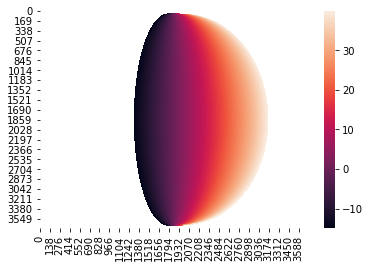

In [34]:
sns.heatmap(lon_array)

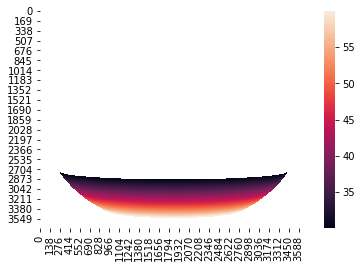

In [35]:
sns.heatmap(lat_array)

In [36]:
lat_nc = rootgrp.variables["lat"][:].data
lon_nc = rootgrp.variables["lon"][:].data

In [37]:
lon = -15
lat = 30

dlon = 0.75/2
dlat = 0.75/2

minLat = lat - dlat
maxLat = lat + dlat

# OBS! Problem with sign when it comes to longitude 
a = lon - dlon
b = lon + dlon
minLon = np.min([a, b])
maxLon = np.max([a, b])

In [38]:
x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
X = np.unique(x_idx)
Y = np.unique(y_idx)

In [39]:
np.mean(lon_nc[X, :][:, Y])

-15.010457

In [40]:
np.mean(lat_nc[X, :][:, Y])

30.000273

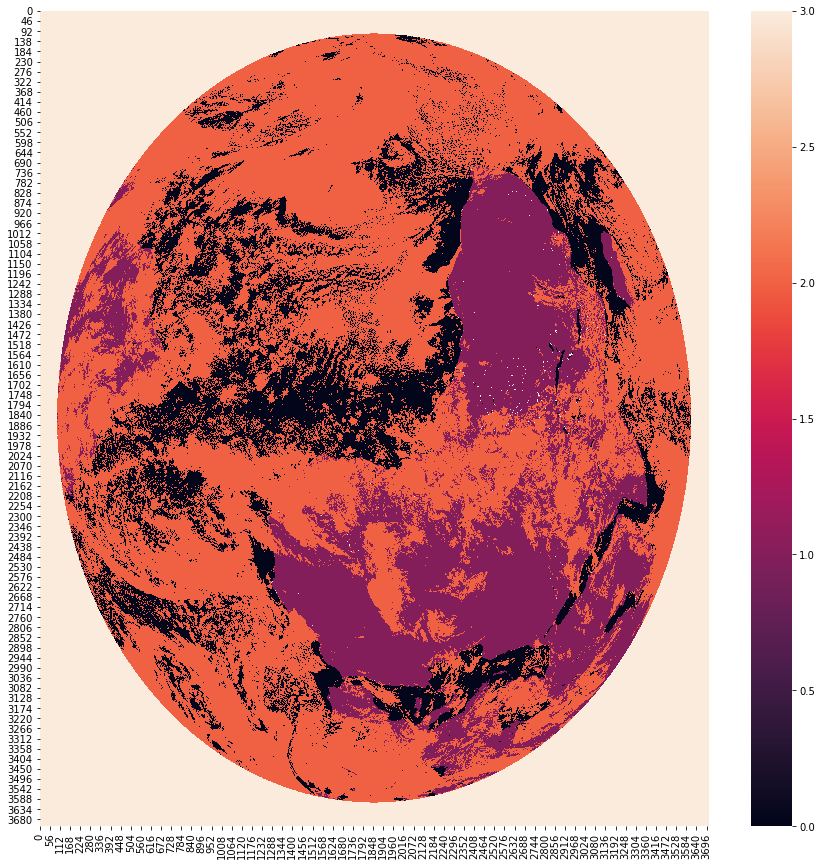

In [41]:
plt.figure(figsize=(15,15))
sns.heatmap(cloud_mask_array)

In [42]:
a = data['CLOUDM_P30_GSV0_I207'].values

In [43]:
a

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

In [44]:
a[a == 3.]= 9999

In [49]:
a[a == 3.]= np.nan

In [50]:
a

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

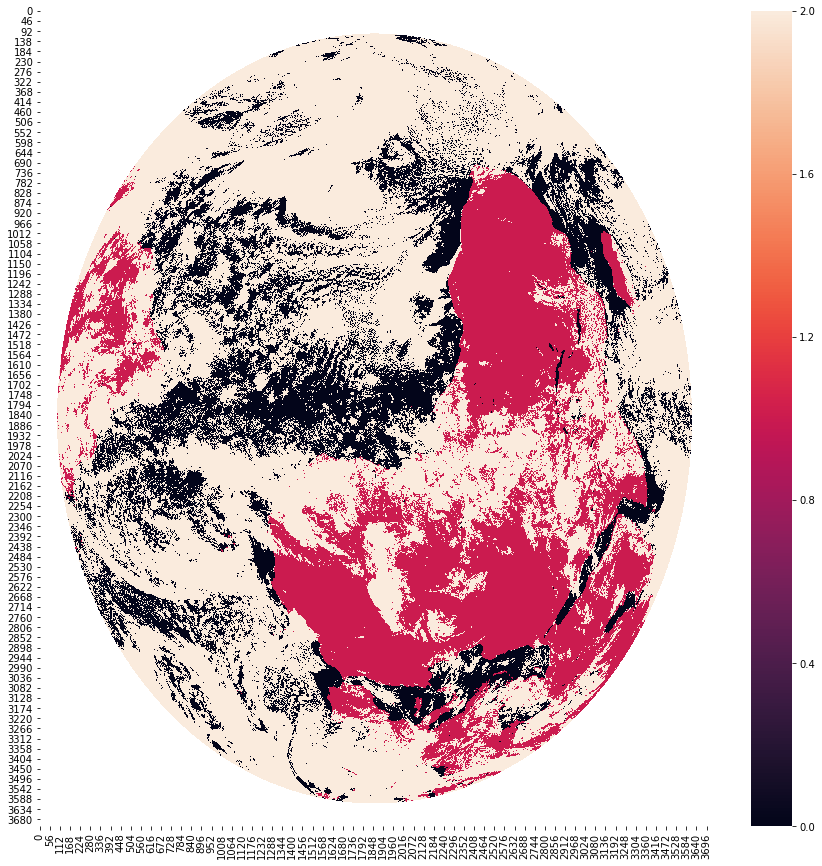

In [51]:
plt.figure(figsize = (15,15) )
sns.heatmap(np.fliplr(a))

In [146]:
def calc_one_mean(lon, lat, lon_nc, lat_nc, clm_grb):
    """
    lon : float 
        single value of the cell you want to calc mean to.
        
    lat : float
        same as above
    
    lon_nc : 2D array
        array containg all the lons fron the netcdf files.
    
    lat_nc : 2D array
        array containg all the lat fron the netcdf files.
    
    clm_grb : 2Darray 
        data from the grib file.
        
    Notes
    ------------------------------
    The grib file needs too be flipped left and right in order to 
    
    
    """
    
    dlon = 0.75/2
    dlat = 0.75/2
    
    minLat = lat - dlat
    maxLat = lat + dlat
    
    # OBS! Problem with sign when it comes to longitude 
    a = lon - dlon
    b = lon + dlon
    minLon = np.min([a, b])
    maxLon = np.max([a, b])
    
    # Find the index of the cell which correspond to the 
    x_idx, y_idx = np.where((lon_nc > minLon) & (lon_nc < maxLon) & (lat_nc > minLat) & (lat_nc < maxLat))
    X = np.unique(x_idx)
    Y = np.unique(y_idx)
    
    #cloud_flipped = np.fliplr(clm_grb) 
    # need to flip the grib file so its on the same format as netcdf file where we get the coordinates.
    
    # TODO: maybee you need to look at the box around the satelitte image 
    meanLon = np.mean(  lon_nc[X, :][:, Y]    )
    meanLat = np.mean(  lat_nc[X, :][:, Y]   )
    
    
    #todo wich back 
    cloud_flipped = clm_grb
    
    # retrieve cloud mask
    submat = cloud_flipped[X, :][:, Y]
    submat[submat == 3.] = np.nan 
    count_nan = (np.isnan(submat)).sum()
    if count_nan  > 0: # 3 denotes of earth disk. The cloud data can only originate from inside the earth disk
        print("OBS the nr 3. lon: {} lat: {}   || meanlon {} mean lat {}".format(lon, lat, meanLon, meanLat))
    submat[submat == 1] = 0 # no cloud over ocean --> no cloud 
    submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction
    cloud_fraction = np.nanmean(submat)
    _x, _y = submat.shape
    count_cells = int(_x*_y)
    
    return cloud_fraction, count_cells, count_nan
    
    

In [147]:
def calc_all(filename, nc_file = nc_files[0]):
    """
    Data from a grib file.
    """
    rootgrp = Dataset(nc_file, "r", format="NETCDF4")
    cloud_mask_array = rootgrp.variables["cloudMask"][:].data
    lat_array = rootgrp.variables["lat"][:].data
    lon_array = rootgrp.variables["lon"][:].data
    
    true_lat = np.arange(30, 58+0.75, 0.75)
    true_lon = np.arange(-15, 40+0.75, 0.75)
    
    data = xr.open_dataset(filename, engine="pynio")
    clm_grb = data['CLOUDM_P30_GSV0_I207'].values 
    
    _x = len(true_lat)
    _y= len(true_lon)
    
    counting_cells = np.zeros((_x, _y))
    cloud_fractions = np.zeros((_x, _y))
    counting_nans = np.zeros((_x, _y))
    
    for i, la in enumerate(true_lat):
        for j, lo in enumerate(true_lon):   
            
            cloud_fraction, count_cells, count_nans = calc_one_mean(lo, 
                                                      la, 
                                                      lon_array, 
                                                      lat_array, 
                                                      clm_grb) # todo swap back to grb fil

            counting_cells[i,j] = count_cells
            cloud_fractions[i,j] = cloud_fraction
            counting_nans[i,j] = count_nans
  
    return cloud_fractions, counting_cells, counting_nans

In [148]:
clm, cnt_cells, cnt_nans = calc_all(filename = grb_file)

OBS the nr 3. lon: 9.75 lat: 30.0   || meanlon 9.748388290405273 mean lat 30.001726150512695
OBS the nr 3. lon: 2.25 lat: 30.75   || meanlon 2.265230417251587 mean lat 30.755407333374023
OBS the nr 3. lon: 9.75 lat: 30.75   || meanlon 9.751562118530273 mean lat 30.736478805541992
OBS the nr 3. lon: 9.0 lat: 32.25   || meanlon 8.984848022460938 mean lat 32.25358581542969
OBS the nr 3. lon: -12.75 lat: 33.0   || meanlon -12.754897117614746 mean lat 33.00773620605469
OBS the nr 3. lon: -11.25 lat: 33.0   || meanlon -11.250741958618164 mean lat 32.98991394042969
OBS the nr 3. lon: -11.25 lat: 33.75   || meanlon -11.24409008026123 mean lat 33.74410629272461
OBS the nr 3. lon: -10.5 lat: 33.75   || meanlon -10.493402481079102 mean lat 33.7637825012207
OBS the nr 3. lon: 6.75 lat: 33.75   || meanlon 6.741674900054932 mean lat 33.73428726196289
OBS the nr 3. lon: -11.25 lat: 34.5   || meanlon -11.258326530456543 mean lat 34.508995056152344
OBS the nr 3. lon: 6.0 lat: 34.5   || meanlon 5.994930

In [149]:
clm

array([[0.        , 0.        , 0.        , ..., 0.85565215, 0.62782609,
        0.32695651],
       [0.11888112, 0.16103059, 0.09615385, ..., 0.81628788, 0.78086954,
        0.74608696],
       [0.23244147, 0.756993  , 0.49125874, ..., 0.73043478, 0.81272727,
        0.93739128],
       ...,
       [1.        , 1.        , 1.        , ..., 0.98913044, 0.98863637,
        0.98996657],
       [1.        , 1.        , 1.        , ..., 0.98550725, 0.96212119,
        0.942029  ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        0.98148149]])

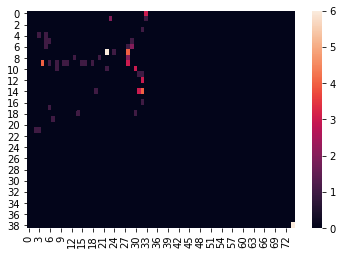

In [150]:
sns.heatmap(cnt_nans)

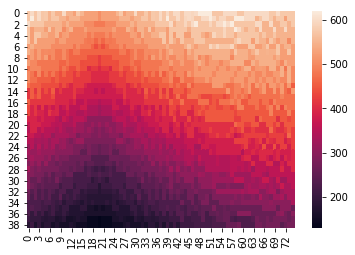

In [151]:
sns.heatmap(cnt_cells)

In [ ]:
sns.heatmap(clm)

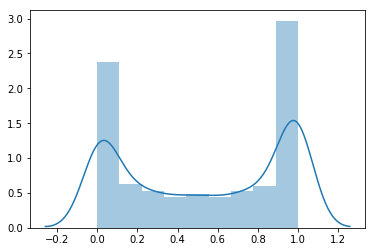

In [124]:
sns.distplot(clm.flatten())

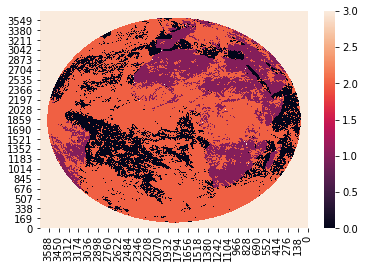

In [234]:
ax = sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)
ax.invert_yaxis()
ax.invert_xaxis()

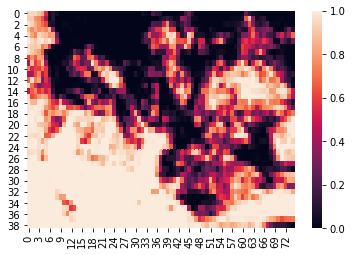

In [125]:
ax = sns.heatmap(clm)
#ax.invert_yaxis()

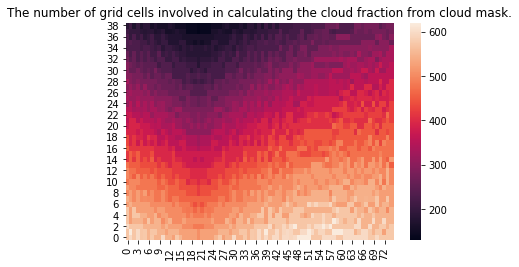

In [128]:
ax = sns.heatmap(cnt_cells)
ax.invert_yaxis()
ax.set_title("The number of grid cells involved in calculating the cloud fraction from cloud mask.");

In [100]:
tcc = clm
lon = np.arange(-15, 40+0.75, 0.75)
lat = np.arange(30, 58+0.75, 0.75)

In [101]:
tcc.shape, lon.shape, lat.shape

((39, 75), (75,), (39,))

In [ ]:
nc_path = '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338648/'
nc_files = glob.glob(nc_path+"*EUMETSAT*.nc")

In [201]:
counter = 0
for filename in grb_files:# grb file of satellite image...
    print(filename)
    if counter == 0:
        print("enters 0")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                         'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                        'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                         coords={'longitude': (['longitude'], lon),
                                 'latitude': (['latitude'], lat), 
                                })

        ts = timestamp(filename)
        ds['time'] = ts

        # Add time as a coordinate and dimension. 
        ds = ds.assign_coords(time = data.time)
        ds = ds.expand_dims(dim = 'time')
        counter += 1

    else:
        print("enters 1")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                             'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                             'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                              coords={'longitude': (['longitude'], lon),
                                      'latitude': (['latitude'], lat), 
                                       })

        ts = timestamp(filename)
        new_ds['time'] = ts

        # Add time as a coordinate and dimension. 
        new_ds = new_ds.assign_coords(time = data.time)
        new_ds = new_ds.expand_dims(dim = 'time')

        ds.merge(new_ds)

        counter += 1

print(ds)

/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612113000.000000000Z-20190612114350-1338650.grb
enters 0
OBS the nr 3. lon: 9.75 lat: 30.0   || meanlon 9.748388290405273 mean lat 30.001726150512695
OBS the nr 3. lon: 2.25 lat: 30.75   || meanlon 2.265230417251587 mean lat 30.755407333374023
OBS the nr 3. lon: 9.75 lat: 30.75   || meanlon 9.751562118530273 mean lat 30.736478805541992
OBS the nr 3. lon: 9.0 lat: 32.25   || meanlon 8.984848022460938 mean lat 32.25358581542969
OBS the nr 3. lon: -12.75 lat: 33.0   || meanlon -12.754897117614746 mean lat 33.00773620605469
OBS the nr 3. lon: -11.25 lat: 33.0   || meanlon -11.250741958618164 mean lat 32.98991394042969
OBS the nr 3. lon: -11.25 lat: 33.75   || meanlon -11.24409008026123 mean lat 33.74410629272461
OBS the nr 3. lon: -10.5 lat: 33.75   || meanlon -10.493402481079102 mean lat 33.7637825012207
OBS the nr 3. lon: 6.75 lat: 33.75   || meanlon 6.74167490005

OBS the nr 3. lon: -10.5 lat: 42.75   || meanlon -10.5004243850708 mean lat 42.74372482299805
OBS the nr 3. lon: -4.5 lat: 43.5   || meanlon -4.499309062957764 mean lat 43.48851776123047
OBS the nr 3. lon: 1.5 lat: 43.5   || meanlon 1.4984437227249146 mean lat 43.509864807128906
OBS the nr 3. lon: 3.75 lat: 43.5   || meanlon 3.756976366043091 mean lat 43.480648040771484
OBS the nr 3. lon: 7.5 lat: 43.5   || meanlon 7.498774528503418 mean lat 43.490169525146484
OBS the nr 3. lon: -9.75 lat: 44.25   || meanlon -9.754262924194336 mean lat 44.258480072021484
OBS the nr 3. lon: -13.5 lat: 45.75   || meanlon -13.50029182434082 mean lat 45.758460998535156
OBS the nr 3. lon: -12.75 lat: 45.75   || meanlon -12.762039184570312 mean lat 45.756343841552734
OBS the nr 3. lon: -14.25 lat: 54.0   || meanlon -14.260198593139648 mean lat 53.99729919433594
OBS the nr 3. lon: -8.25 lat: 56.25   || meanlon -8.233651161193848 mean lat 56.23948287963867
OBS the nr 3. lon: -8.25 lat: 58.5   || meanlon -8.276

MergeError: conflicting values for variable 'nr_nans' on objects to be combined:
first value: <xarray.Variable (time: 1, latitude: 39, longitude: 75)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 6.]]])
second value: <xarray.Variable (time: 1, latitude: 39, longitude: 75)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 6.]]])

In [192]:
new_ds

<xarray.Dataset>
Dimensions:    (latitude: 39, logitude: 75, longitude: 75, time: 1)
Coordinates:
  * longitude  (longitude) float64 -15.0 -14.25 -13.5 -12.75 ... 39.0 39.75 40.5
  * latitude   (latitude) float64 30.0 30.75 31.5 32.25 ... 57.0 57.75 58.5
  * time       (time) datetime64[ns] 2019-06-12T11:30:00
Dimensions without coordinates: logitude
Data variables:
    tcc        (time, latitude, logitude) float64 0.9336 0.9465 ... 0.06159 nan
    nr_nans    (time, latitude, logitude) float64 0.0 0.0 0.0 ... 0.0 0.0 6.0
    nr_cells   (time, latitude, logitude) float64 572.0 598.0 ... 276.0 276.0

In [197]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 39, logitude: 75, longitude: 75, time: 1)
Coordinates:
  * longitude  (longitude) float64 -15.0 -14.25 -13.5 -12.75 ... 39.0 39.75 40.5
  * latitude   (latitude) float64 30.0 30.75 31.5 32.25 ... 57.0 57.75 58.5
  * time       (time) datetime64[ns] 2019-06-12T11:30:00
Dimensions without coordinates: logitude
Data variables:
    tcc        (time, latitude, logitude) float64 0.9336 0.9465 ... 0.06159 nan
    nr_nans    (time, latitude, logitude) float64 0.0 0.0 0.0 ... 0.0 0.0 6.0
    nr_cells   (time, latitude, logitude) float64 572.0 598.0 ... 276.0 276.0

In [198]:
new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                     'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                     'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                    
                      coords={'longitude': (['longitude'], lon),
                              'latitude': (['latitude'], lat) })

ts = timestamp(filename)
new_ds['time'] = ts

# Add time as a coordinate and dimension. 
new_ds = new_ds.assign_coords(time = data.time)
new_ds = new_ds.expand_dims(dim = 'time')

In [199]:
new_ds

<xarray.Dataset>
Dimensions:    (latitude: 39, longitude: 75, time: 1)
Coordinates:
  * longitude  (longitude) float64 -15.0 -14.25 -13.5 -12.75 ... 39.0 39.75 40.5
  * latitude   (latitude) float64 30.0 30.75 31.5 32.25 ... 57.0 57.75 58.5
  * time       (time) datetime64[ns] 2019-06-12T11:30:00
Data variables:
    tcc        (time, latitude, longitude) float64 0.9336 0.9465 ... 0.06159 nan
    nr_nans    (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 6.0
    nr_cells   (time, latitude, longitude) float64 572.0 598.0 ... 276.0 276.0

In [ ]:
ds

In [ ]:
new_ds

In [171]:
def create_grb_file_by_filenames(filenames):
    counter = 0
    for filename in filenames:# grb file of satellite image...
        print()
        if counter == 0:
            print("enters 0")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension. 
            ds = ds.assign_coords(time = data.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1
            
        else:
            print("enters 1")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            new_ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension. 
            new_ds = new_ds.assign_coords(time = data.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            ds.merge(new_ds)
            
            counter += 1
            
    print(ds)
    return 

In [167]:
grb_files

['/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612113000.000000000Z-20190612114350-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190613053000.000000000Z-20190613054348-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612233000.000000000Z-20190612234401-1338650.grb',
 '/home/hanna/Desktop/sat_comparison/archive.eumetsat.int/umarf/onlinedownload/hannasv/1338650/MSG4-SEVI-MSGCLMK-0100-0100-20190612173000.000000000Z-20190612174350-1338650.grb']

In [170]:
new_ds

NameError: name 'new_ds' is not defined

In [172]:
create_grb_file_by_filenames(grb_files)


enters 0
OBS the nr 3. lon: 9.75 lat: 30.0   || meanlon 9.748388290405273 mean lat 30.001726150512695
OBS the nr 3. lon: 2.25 lat: 30.75   || meanlon 2.265230417251587 mean lat 30.755407333374023
OBS the nr 3. lon: 9.75 lat: 30.75   || meanlon 9.751562118530273 mean lat 30.736478805541992
OBS the nr 3. lon: 9.0 lat: 32.25   || meanlon 8.984848022460938 mean lat 32.25358581542969
OBS the nr 3. lon: -12.75 lat: 33.0   || meanlon -12.754897117614746 mean lat 33.00773620605469
OBS the nr 3. lon: -11.25 lat: 33.0   || meanlon -11.250741958618164 mean lat 32.98991394042969
OBS the nr 3. lon: -11.25 lat: 33.75   || meanlon -11.24409008026123 mean lat 33.74410629272461
OBS the nr 3. lon: -10.5 lat: 33.75   || meanlon -10.493402481079102 mean lat 33.7637825012207
OBS the nr 3. lon: 6.75 lat: 33.75   || meanlon 6.741674900054932 mean lat 33.73428726196289
OBS the nr 3. lon: -11.25 lat: 34.5   || meanlon -11.258326530456543 mean lat 34.508995056152344
OBS the nr 3. lon: 6.0 lat: 34.5   || meanlo

OBS the nr 3. lon: 7.5 lat: 43.5   || meanlon 7.498774528503418 mean lat 43.490169525146484
OBS the nr 3. lon: -9.75 lat: 44.25   || meanlon -9.754262924194336 mean lat 44.258480072021484
OBS the nr 3. lon: -13.5 lat: 45.75   || meanlon -13.50029182434082 mean lat 45.758460998535156
OBS the nr 3. lon: -12.75 lat: 45.75   || meanlon -12.762039184570312 mean lat 45.756343841552734
OBS the nr 3. lon: -14.25 lat: 54.0   || meanlon -14.260198593139648 mean lat 53.99729919433594
OBS the nr 3. lon: -8.25 lat: 56.25   || meanlon -8.233651161193848 mean lat 56.23948287963867
OBS the nr 3. lon: -8.25 lat: 58.5   || meanlon -8.276021003723145 mean lat 58.518310546875
OBS the nr 3. lon: -6.75 lat: 58.5   || meanlon -6.7428741455078125 mean lat 58.4791259765625
OBS the nr 3. lon: 40.5 lat: 58.5   || meanlon 40.47765350341797 mean lat 58.500579833984375


MergeError: conflicting values for variable 'nr_nans' on objects to be combined:
first value: <xarray.Variable (time: 1, latitude: 39, logitude: 75)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 6.]]])
second value: <xarray.Variable (time: 1, latitude: 39, logitude: 75)>
array([[[0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 0.],
        ...,
        [0., 0., ..., 0., 0.],
        [0., 0., ..., 0., 6.]]])

In [168]:
ds

<xarray.Dataset>
Dimensions:    (time: 1, x: 39, y: 75)
Coordinates:
    longitude  (y) float64 -15.0 -14.25 -13.5 -12.75 ... 38.25 39.0 39.75 40.5
    latitude   (x) float64 30.0 30.75 31.5 32.25 33.0 ... 56.25 57.0 57.75 58.5
  * time       (time) datetime64[ns] 2019-06-12T11:30:00
Dimensions without coordinates: x, y
Data variables:
    tcc        (time, x, y) float64 0.9336 0.9465 0.9493 ... 0.1174 0.06159 nan
    nr_nans    (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 6.0
    nr_cells   (time, x, y) float64 572.0 598.0 572.0 ... 264.0 276.0 276.0

In [173]:
new_ds

NameError: name 'new_ds' is not defined

In [133]:
ol

In [134]:
ds

<xarray.Dataset>
Dimensions:    (time: 1, x: 39, y: 75)
Coordinates:
    longitude  (y) float64 -15.0 -14.25 -13.5 -12.75 ... 38.25 39.0 39.75 40.5
    latitude   (x) float64 30.0 30.75 31.5 32.25 33.0 ... 56.25 57.0 57.75 58.5
  * time       (time) datetime64[ns] 2019-06-12T11:30:00
Dimensions without coordinates: x, y
Data variables:
    tcc        (time, x, y) float64 0.9336 0.9465 0.9493 ... 0.1174 0.06159 nan
    nr_nans    (time, x, y) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 6.0
    nr_cells   (time, x, y) float64 572.0 598.0 572.0 ... 264.0 276.0 276.0

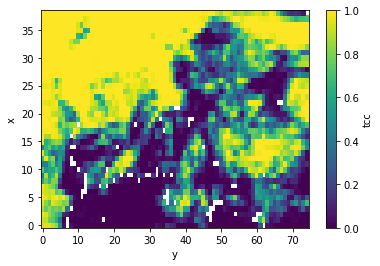

In [119]:
ds.tcc.plot()

In [231]:
import seaborn as sns

In [196]:
cloud_mask_array = np.flip(rootgrp.variables["cloudMask"][:].data)

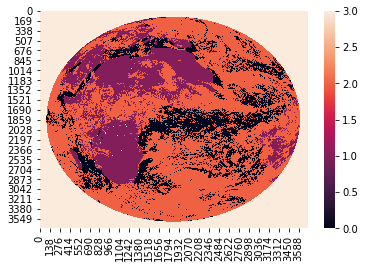

In [197]:
sns.heatmap(cloud_mask_array) # nc with correct coordinates

In [185]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

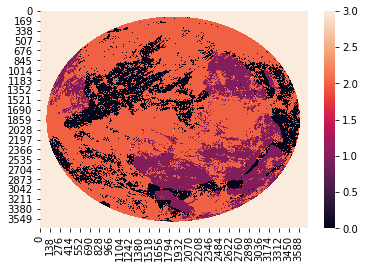

In [186]:
sns.heatmap(a)

In [179]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

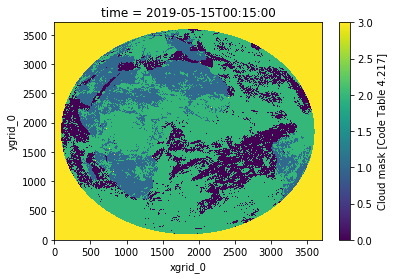

In [177]:
data['CLOUDM_P30_GSV0_I207'].plot()

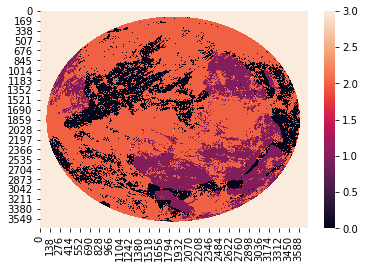

In [180]:
sns.heatmap(a)

In [115]:
rows = cloud_mask_array[X, :]
submat = rows[:, Y]
submat.shape

(23, 27)

In [181]:
# Todo plot netcdf of se hvordan det ser ut 

## OBS! sjekk om det ceteret i cellen som lat, lon. Hvordan korrigere for dette. 

In [119]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [120]:
submat[submat == 1] = 0 # no cloud over ocean --> no cloud 

In [ ]:
submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction

In [123]:
submat.mean()

0.85507244

In [116]:
sum(submat == 3)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0])

# Check that the cloud cover only contain 0,1,2 replace all 2
## replace so that its zero and 0 and 1. 
### Maybee you should replace 

In [193]:
row = lon_array[X,:]
row[:,Y]

array([[-14.996124 , -14.962436 , -14.928756 , -14.895085 , -14.8614235,
        -14.82777  , -14.7941265, -14.760491 , -14.726865 , -14.693248 ,
        -14.659638 , -14.626039 , -14.592447 , -14.558865 , -14.5252905,
        -14.491725 , -14.458168 , -14.42462  , -14.39108  , -14.357549 ,
        -14.324026 , -14.290512 , -14.257007 , -14.22351  , -14.190021 ,
        -14.15654  , -14.123068 ],
       [-15.002226 , -14.968522 , -14.934828 , -14.901142 , -14.867465 ,
        -14.833797 , -14.800138 , -14.766488 , -14.732847 , -14.699215 ,
        -14.665591 , -14.631976 , -14.59837  , -14.564772 , -14.531183 ,
        -14.497602 , -14.464031 , -14.430469 , -14.396914 , -14.363368 ,
        -14.32983  , -14.296302 , -14.262781 , -14.229269 , -14.1957655,
        -14.162271 , -14.128784 ],
       [-15.008342 , -14.974623 , -14.940913 , -14.907213 , -14.873521 ,
        -14.839838 , -14.806164 , -14.772499 , -14.738843 , -14.705195 ,
        -14.671556 , -14.637927 , -14.604306 , -14.570

## Make a map 

In [46]:
import cartopy.crs as ccrs

In [49]:
import cartopy as cp
def plot_map(lat = (30,60), lon = (-30,35), path = "maps/",
    title = "MeteoSat vision Europa", filename = "MeteoSat_vision_Europa.png"):
    """
    Plot map defined by lat lon, default Europe.
    Path should be to lagringshotell, don't save png's on git ...
    """
    plt.figure(figsize = (15,15))
    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.add_feature(cp.feature.OCEAN, zorder=0)
    ax.add_feature(cp.feature.LAND, zorder=0, edgecolor='black')
    ax.coastlines(resolution='50m')
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], ccrs.PlateCarree())

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.)

    ax.text(0.03, 0.07, "MeteoSat vision Europa", transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #plt.savefig(path + filename, bbox_inces = "thight")
    plt.show()

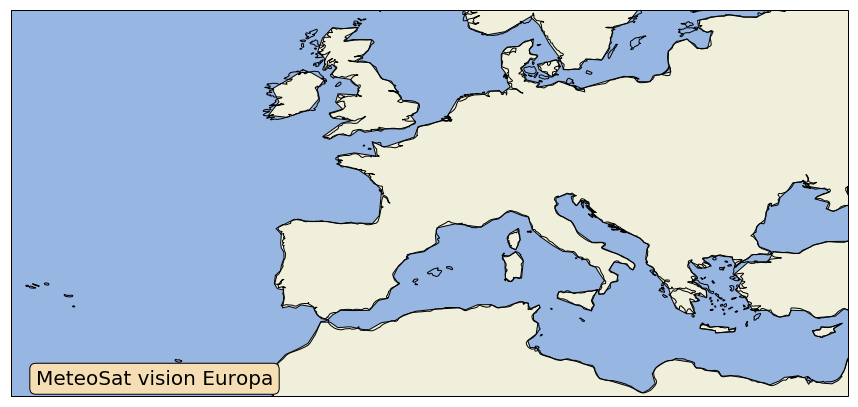

In [50]:
plot_map()

### FIgure out how to crop this and not ge a disk 

In [44]:
d = data['p260537'].values

In [45]:
dim = int(np.sqrt(len(d)))

In [46]:
dim

3712

In [47]:
d = d.reshape((dim, dim ))

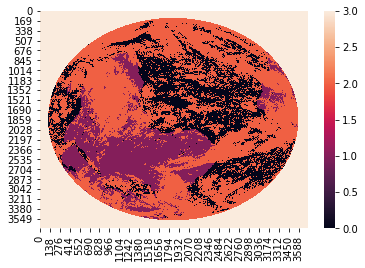

In [48]:
sns.heatmap(d)

In [4]:
path = '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/'

In [5]:
files = glob.glob(path+"*.grb")

In [6]:
files

['/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605000000.000000000Z-20190605001353-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605060000.000000000Z-20190605061402-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605120000.000000000Z-20190605121404-1337166.grb',
 '/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605180000.000000000Z-20190605181414-1337166.grb']

In [7]:
first_file = files[0]

In [8]:
first_file

'/uio/hume/student-u89/hannasv/tempSAT/archive.eumetsat.int/umarf/onlinedownload/hannasv/1337166/MSG4-SEVI-MSGCLMK-0100-0100-20190605000000.000000000Z-20190605001353-1337166.grb'

In [21]:
import seaborn as sns